Importing libraries and reading the data

In [146]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from itertools import combinations 
from sklearn.cluster import KMeans
import folium

customer = pd.read_csv('Customer_Data.csv')
print(customer.shape)
print("\n", customer.columns.values)
print("\n", customer.dtypes)
customer.head()

(79, 6)

 ['Latitude' 'Longitude' 'Apparel' 'Books' 'Electronics' 'Grocery']

 Latitude       float64
Longitude      float64
Apparel        float64
Books          float64
Electronics    float64
Grocery        float64
dtype: object


,Latitude,Longitude,Apparel,Books,Electronics,Grocery
0,30.453290,76.394585,6.83,4.34,0.77,14.58
1,26.301717,80.133402,15.48,9.89,0.93,1.38
2,10.482971,76.384688,1.21,8.26,0.57,12.96
3,26.301717,80.130000,3.04,9.54,0.53,15.58
4,31.022162,76.724332,6.74,0.21,14.40,1.14


Scatter Plots of Purchase vs Latitude and Longitude

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

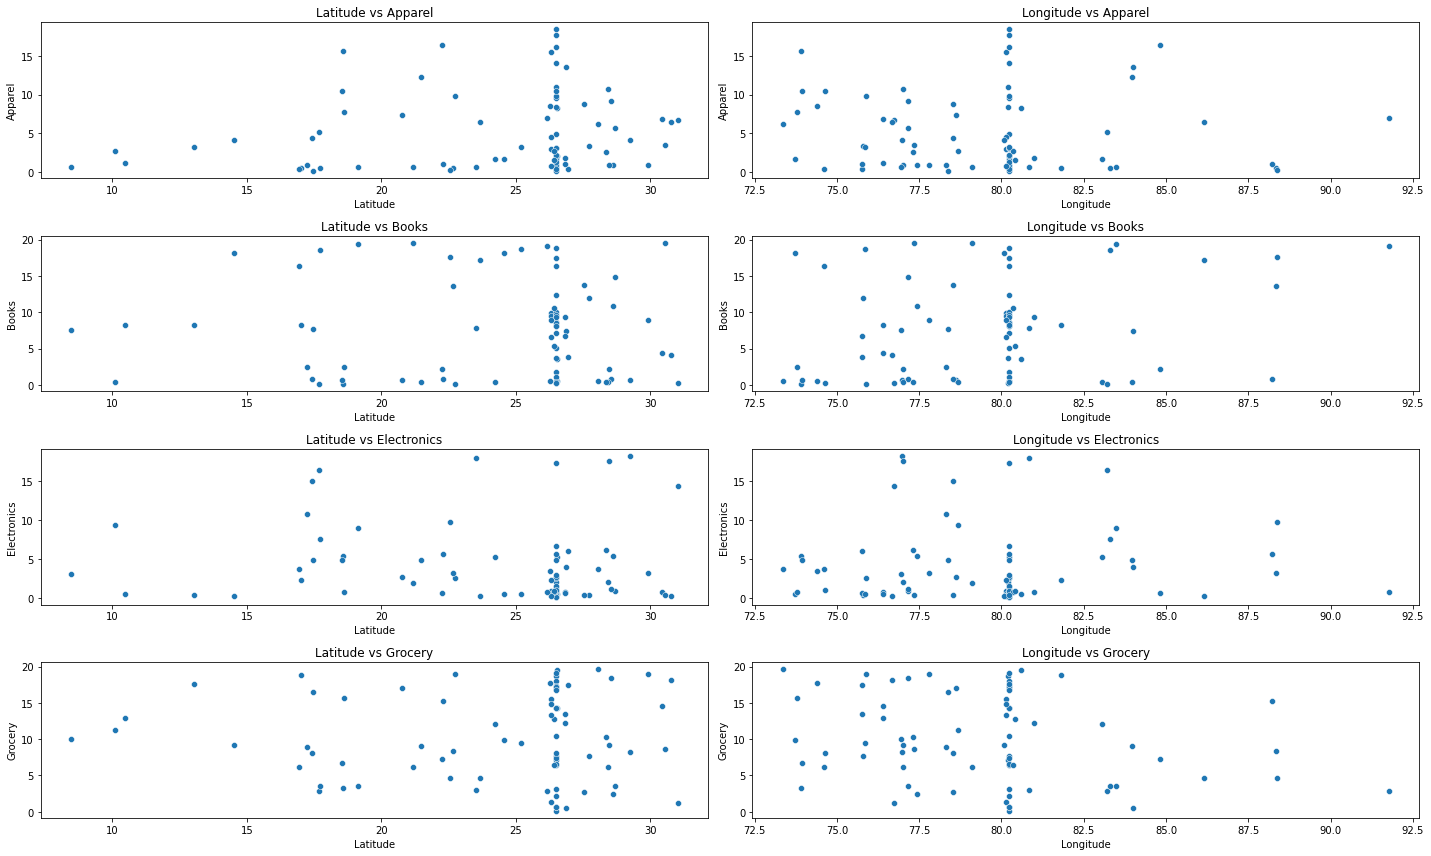

In [147]:
def scatter(x,y,fig):
    plt.subplot(4,2,fig)
    sns.scatterplot(customer[x], customer[y])
    plt.title(x+' vs '+y)
    plt.ylabel(y)
    plt.xlabel(x)

plt.figure(figsize=(20,12))

scatter('Latitude','Apparel', 1)
scatter('Longitude','Apparel', 2)
scatter('Latitude','Books', 3)
scatter('Longitude','Books', 4)
scatter('Latitude','Electronics', 5)
scatter('Longitude','Electronics', 6)
scatter('Latitude','Grocery', 7)
scatter('Longitude','Grocery', 8)
plt.tight_layout()
plt.show()

Plotting the Purchases on map of India
The Radius of Marker represents weight of items purchased

Apparel- brown;  Books- red;  Electronics- Orange;  Grocery- Yellow

In [148]:
m = folium.Map(location=customer[['Latitude', 'Longitude']].mean(), zoom_start=5,min_zoom=5,max_zoom=10)
color_options = {'Apparel': 'brown',
                 'Books': 'red',
                 'Electronics': 'orange',
                 'Grocery': 'yellow'}
for val in customer.columns.values[2:]:
  for _, row in customer.iterrows():
      folium.CircleMarker(location=[row['Latitude'], \
                                    row['Longitude']],\
                          radius=(row[val]**0.75),\
                          color=color_options.get(str(val), 'gray'),\
                          opacity=0.7).add_to(m)
m.fit_bounds(customer[['Latitude', 'Longitude']].values.tolist())
m

Summing up the weight of items and storing it in new varriable

In [149]:
customer['Calc_Vol'] = customer['Grocery'] + customer['Apparel'] + customer['Books'] + customer['Electronics']
customer.head()

,Latitude,Longitude,Apparel,Books,Electronics,Grocery,Calc_Vol
0,30.453290,76.394585,6.83,4.34,0.77,14.58,26.52
1,26.301717,80.133402,15.48,9.89,0.93,1.38,27.68
2,10.482971,76.384688,1.21,8.26,0.57,12.96,23.00
3,26.301717,80.130000,3.04,9.54,0.53,15.58,28.69
4,31.022162,76.724332,6.74,0.21,14.40,1.14,22.49


Fitting K-means algorithm on the weighted data points taking 8 centroids

In [150]:
kmeans = KMeans(n_clusters=8, 
                random_state=0).fit(customer.loc[customer['Calc_Vol']>0, ['Latitude', 
                                                                  'Longitude']], 
                                  sample_weight=customer.loc[customer['Calc_Vol']>0, 
                                                           'Calc_Vol'])

cogs = kmeans.cluster_centers_
cogs = pd.DataFrame(cogs, columns=['Latitude',
                                   'Longitude'])

customer['Cluster'] = kmeans.predict(customer[['Latitude', 'Longitude']])
cogs = cogs.join(customer.groupby('Cluster')['Calc_Vol'].sum())

customer = customer.join(cogs, on='Cluster', rsuffix='_COG')
customer.head()

,Latitude,Longitude,Apparel,Books,Electronics,Grocery,Calc_Vol,Cluster,Latitude_COG,Longitude_COG,Calc_Vol_COG
0,30.453290,76.394585,6.83,4.34,0.77,14.58,26.52,5,29.242722,77.103278,365.57
1,26.301717,80.133402,15.48,9.89,0.93,1.38,27.68,1,26.342195,80.458629,843.47
2,10.482971,76.384688,1.21,8.26,0.57,12.96,23.00,3,11.651118,78.683748,129.40
3,26.301717,80.130000,3.04,9.54,0.53,15.58,28.69,1,26.342195,80.458629,843.47
4,31.022162,76.724332,6.74,0.21,14.40,1.14,22.49,5,29.242722,77.103278,365.57


**Plotting the desired location of warehouses in India** (Assuming each warehouse
has sufficient capacity to serve all the customers for all the product types)

In [151]:
# Add flow lines to centers of gravity to map
for _, row in customer.iterrows():
    # Flow lines
        folium.PolyLine([(row['Latitude'],\
                          row['Longitude']),\
                         (row['Latitude_COG'],\
                          row['Longitude_COG'])],\
                        color='blue',\
                        weight=2,\
                        opacity=0.5).add_to(m)
                        
# Add centers of gravity to map
for _, row in cogs.iterrows():
    # New centers of gravity
    folium.CircleMarker(location=[row['Latitude'],
                                  row['Longitude']],
                        radius=5,
                        color='blue',
                        tooltip=row['Calc_Vol'],fill=True).add_to(m)
    
# Show map
m